In [ ]:
from spikingjelly.spikingjelly.activation_based.neuron import ParametricLIFNode
from jaxtyping import Float, Int
from torch import Tensor

import torch
import matplotlib.pyplot as plt
import numpy as np
import spikingjelly.activation_based as snn
from spikingjelly.spikingjelly.activation_based import surrogate, neuron, functional

In [13]:
from sklearn.model_selection import train_test_split

def generate_l1_dataset(num_samples: int, 
                        vector_dim: int, 
                        max_val: float = 10.0) -> tuple[np.ndarray, np.ndarray]:
    """
    L1 거리 예측을 위한 데이터셋을 생성합니다.

    Args:
        num_samples: 생성할 샘플의 수.
        vector_dim: 각 벡터의 차원.
        max_val: 벡터 요소의 최대값.

    Returns:
        X: 입력 데이터 (두 벡터가 수평으로 결합됨). Shape: (num_samples, vector_dim * 2)
        y: 출력 레이블 (L1 거리). Shape: (num_samples, 1)
    """
    
    # 1. 두 개의 랜덤 벡터 세트 생성
    # np.random.uniform을 사용하여 (num_samples, vector_dim) 크기의 행렬 두 개를 생성
    vectors1 = np.random.uniform(0, max_val, size=(num_samples, vector_dim))
    vectors2 = np.random.uniform(0, max_val, size=(num_samples, vector_dim))
    
    # 2. L1 거리 계산 (레이블 y)
    # axis=1을 기준으로 합산하여 각 샘플(행)의 L1 거리를 계산
    l1_distances = np.sum(np.abs(vectors1 - vectors2), axis=1)
    
    # 3. 입력 데이터 X 생성
    # 두 벡터 세트를 수평으로 결합 (concatenate)
    # shape: (num_samples, vector_dim + vector_dim)
    X = np.hstack([vectors1, vectors2])
    
    # 4. y를 (num_samples, 1) 형태로 변환 (ML 모델에 적합)
    y = l1_distances.reshape(-1, 1)
    
    return X, y

# --- 데이터셋 생성 ---
NUM_SAMPLES = 10000  # 총 1만 개의 샘플 생성
VECTOR_DIM = 10      # 각 벡터는 10차원
MIN_VAL = -50.0
MAX_VAL = 50.0

X_data, y_data = generate_l1_dataset(NUM_SAMPLES, VECTOR_DIM, MAX_VAL)

print(f"데이터 생성 완료:")
print(f"  입력 X_data shape: {X_data.shape}")  # (10000, 20)
print(f"  출력 y_data shape: {y_data.shape}")  # (10000, 1)

데이터 생성 완료:
  입력 X_data shape: (10000, 20)
  출력 y_data shape: (10000, 1)


--- 원본 데이터 ---
X_data shape: (1000, 10)
첫 번째 샘플 (일부): [38.21281629 16.21191456 22.1378445  26.87285064 11.10984076]

--- Latency Coding 결과 ---
Spiked Data shape: (20, 1000, 10)

--- 첫 번째 샘플 시각화 ---
Original Data[0] (first 5): [38.21281629 16.21191456 22.1378445  26.87285064 11.10984076]
Normalized Data[0] (first 5): [0.76427768 0.32424735 0.44276926 0.53747203 0.22220302]


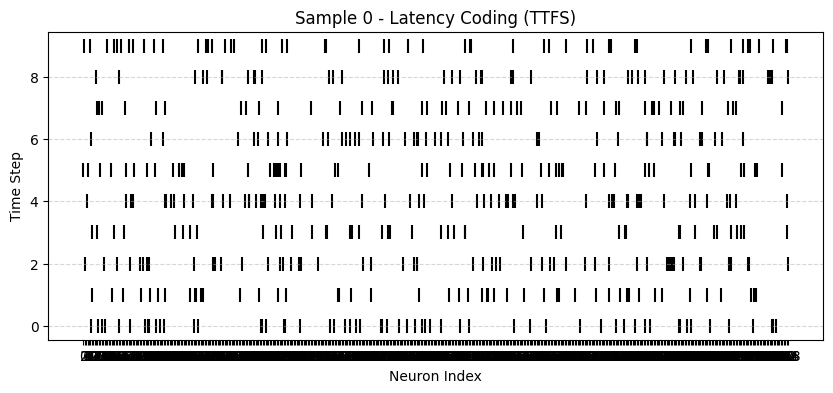

In [14]:
#TODO: Test time-shift invariant!
def encode_temporal(X_data:np.ndarray, time_steps:int, time_norm:bool=False):
    """
    입력 데이터를 Latency Coding(TTFS)으로 변환합니다.
    강한 입력(절댓값) -> 빠른 스파이크, 약한 입력 -> 늦은 스파이크.
    음수와 양수를 별도 채널로 분리합니다.

    Args:
        X_data (np.ndarray): 입력 데이터 (N, num_features)
        time_steps (int): 총 시뮬레이션 시간 단계.

    Returns:
        np.ndarray: 인코딩된 스파이크 데이터 (time_steps, N, num_features)
    """
    num_samples, num_features = X_data.shape
    max_val = np.max(X_data)
    
    if time_norm:
        X_data -= np.min(X_data, axis=1, keepdims=True)
    X_norm = (X_data * (time_steps-1)) / max_val
    X_pos = np.floor(X_norm).astype(np.int32)
    spikes_out = np.zeros((time_steps, num_samples, num_features), dtype=np.float32)

    for i in range(num_samples):
        for j in range(num_features):
            spikes_out[X_pos[i, j], i, j] = 1.0

    return spikes_out

# 파라미터 설정
NUM_SAMPLES = 1000
VECTOR_DIM = 5      # 5차원 벡터 2개 (총 10개 피처)
MIN_VAL = -50.0
MAX_VAL = 50.0
TIME_STEPS = 20     # SNN을 20 타임스텝 동안 실행

# 1. 원본 데이터 생성
X_data, y_data = generate_l1_dataset(NUM_SAMPLES, VECTOR_DIM, MAX_VAL)

print(f"--- 원본 데이터 ---")
print(f"X_data shape: {X_data.shape}") # (1000, 10)
print(f"첫 번째 샘플 (일부): {X_data[0, :5]}")

# 2. Latency Coding 실행
spiked_latency = encode_temporal(X_data, TIME_STEPS)

print(f"\n--- Latency Coding 결과 ---")
print(f"Spiked Data shape: {spiked_latency.shape}") # (1000, 20, 20)
# (N, T, D*4) -> (1000, 20, 5*4=20)

# ==========================================================
# 시각화: 첫 번째 샘플 인코딩 결과 비교
# ==========================================================
def plot_spike_raster(spike_data, title):
    """스파이크 데이터를 래스터 플롯으로 시각화합니다."""
    # spike_data shape: (time_steps, num_features)
    time_steps, num_features = spike_data.shape
    
    # 스파이크가 발생한 시간(y)과 뉴런 인덱스(x) 찾기
    time_idx, neuron_idx = np.where(spike_data.T == 1)
    
    plt.figure(figsize=(10, 4))
    plt.scatter(neuron_idx, time_idx, marker='|', s=100, color='black')
    plt.xlabel("Neuron Index")
    plt.ylabel("Time Step")
    plt.title(title)
    plt.yticks(range(0, num_features, 2))
    plt.xticks(range(0, time_steps, 2))
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

print("\n--- 첫 번째 샘플 시각화 ---")

# 원본 데이터 (첫 5개 피처만 확인)
original_sample = X_data[0]
print(f"Original Data[0] (first 5): {original_sample[:5]}")
# 정규화된 값 (참고용)
norm_sample = original_sample / np.max(X_data)
print(f"Normalized Data[0] (first 5): {norm_sample[:5]}")

# Latency Coding 시각화
# (T, num_features*2)
plot_spike_raster(spiked_latency[0], f"Sample 0 - Latency Coding (TTFS)")

In [16]:
class CCEncoder(torch.nn.Module):
    def __init__(self, input_dim:int,n_acc:int):
        """
        Cross-correlation encoder initialization.
        
        :param self: 설명
        :param n_acc: 설명
        """
        super(CCEncoder, self).__init__()
        self.n_acc = n_acc
        self.model = torch.nn.Sequential(
            torch.nn.Linear(2 * input_dim, n_acc),
            ParametricLIFNode()
        )

    def forward(self, x:tuple[Float[Tensor, "T N D"], Float[Tensor, "T N D"]]):
        """
        Compute the correlation between two input tensors.
        
        :param self: 설명
        :param x: 설명
        :type x: tuple[torch.Tensor, torch.Tensor]
        """
        q, k = x
        x = self.model(torch.cat((q, k), dim=-1))
        return x
